# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [16]:
import gym
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [17]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.02656584  0.22085417 -0.00924969 -0.27218288] 1 1.0 False {}
state, action, reward, done, info
[ 0.03098292  0.41610688 -0.01469334 -0.56776878] 1 1.0 False {}
state, action, reward, done, info
[ 0.03930506  0.22119408 -0.02604872 -0.27975083] 0 1.0 False {}
state, action, reward, done, info
[ 0.04372894  0.02645321 -0.03164374  0.00460391] 0 1.0 False {}
state, action, reward, done, info
[ 0.044258    0.22201436 -0.03155166 -0.29789265] 1 1.0 False {}
state, action, reward, done, info
[ 0.04869829  0.02735605 -0.03750951 -0.01532516] 0 1.0 False {}
state, action, reward, done, info
[ 0.04924541  0.22299529 -0.03781602 -0.31960282] 1 1.0 False {}
state, action, reward, done, info
[ 0.05370532  0.41863484 -0.04420807 -0.62396759] 1 1.0 False {}
state, action, reward, done, info
[ 0.06207801  0.61434521 -0.05668742 -0.93023928] 1 1.0 False {}
state, action, reward, done, info
[ 0.07436492  0.81018457 -0.07529221 -1.24018363] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [18]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
0.8101845749052476 -1.2401836323838642


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [19]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # nextQs calculated using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [20]:
# Generator: Generating the actions
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [21]:
def model_loss(states, actions, nextQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # Masking the actions logits
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [22]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [23]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [24]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [25]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [29]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [30]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [31]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [32]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = [] # accuracy
q_loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            
            # Masking the nextQs using dones/end-of-episodes which defines the goal/task in this episode
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Updating the model: Calculating Qs using states and actions and Qt = rs/qs + (gamma * nextQs) 
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.nextQs: nextQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 4 Training q_loss: 0.0039 Explore P: 0.9996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 21 Training q_loss: 0.0802 Explore P: 0.9975
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 40 Training q_loss: 0.3985 Explore P: 0.9936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 20 Training q_loss: 1.4075 Explore P: 0.9916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 36 Total reward: 29 Training q_loss: 324102.2812 Explore P: 0.9306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 37 Training q_loss: 149156.9531 Explore P: 0.9272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 11 Training q_loss: 192557.2656 Explore P: 0.9262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 13 Training q_loss: 131776.4375 Explore P: 0.9250
-------------------------------------------------------------------------------
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 12 Training q_loss: 46301.1250 Explore P: 0.8674
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 11 Training q_loss: 36953.1992 Explore P: 0.8665
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 18 Training q_loss: 37012.2031 Explore P: 0.8649
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 69 Training q_loss: 52833.1758 Explore P: 0.8590
-------------------------------------------------------------------------------
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 106 Total reward: 53 Training q_loss: 86184.3828 Explore P: 0.7753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 8 Training q_loss: 57660.8594 Explore P: 0.7746
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 66 Training q_loss: 23999.9219 Explore P: 0.7696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 15 Training q_loss: 99246.7188 Explore P: 0.7685
-------------------------------------------------------------------------------
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 142 Total reward: 27 Training q_loss: 60489356.0000 Explore P: 0.6594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 33 Training q_loss: 55025736.0000 Explore P: 0.6572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 134 Training q_loss: 148164960.0000 Explore P: 0.6486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 27 Training q_loss: 151480976.0000 Explore P: 0.6469
-------------------------------------------------------------------------------
-----------------------------------------

-------------------------------------------------------------------------------
Episode: 176 Total reward: 71 Training q_loss: 956601860096.0000 Explore P: 0.4323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 159 Training q_loss: 1311131435008.0000 Explore P: 0.4256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 87 Training q_loss: 409116901376.0000 Explore P: 0.4220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 283 Training q_loss: 940612255744.0000 Explore P: 0.4105
-------------------------------------------------------------------------------
-------------------------

-------------------------------------------------------------------------------
Episode: 210 Total reward: 499 Training q_loss: 225729807646720.0000 Explore P: 0.1408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 498 Training q_loss: 156436717895680.0000 Explore P: 0.1344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 324 Training q_loss: 271618077097984.0000 Explore P: 0.1305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 435 Training q_loss: 25798404734976.0000 Explore P: 0.1253
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 244 Total reward: 499 Training q_loss: 1544371052740608.0000 Explore P: 0.0363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 499 Training q_loss: 3145774707769344.0000 Explore P: 0.0350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 499 Training q_loss: 8322740381548544.0000 Explore P: 0.0338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 499 Training q_loss: 2700776099020800.0000 Explore P: 0.0327
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 277 Total reward: 499 Training q_loss: 493118045795909632.0000 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 499 Training q_loss: 510032829598400512.0000 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 499 Training q_loss: 577155025176887296.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 499 Training q_loss: 596151493728403456.0000 Explore P: 0.0147
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 310 Total reward: 499 Training q_loss: 1492280270961770496.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 499 Training q_loss: 1109385929388195840.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 499 Training q_loss: 1244728114186027008.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 499 Training q_loss: 1099528876364660736.0000 Explore P: 0.0109
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 343 Total reward: 499 Training q_loss: 1692276075935039488.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 499 Training q_loss: 1972650304067338240.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 499 Training q_loss: 2758837676688801792.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 499 Training q_loss: 2416956905537667072.0000 Explore P: 0.0102
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 376 Total reward: 499 Training q_loss: 3430739061940158464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 377 Total reward: 499 Training q_loss: 4815366149426380800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 378 Total reward: 499 Training q_loss: 3246296536136548352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 379 Total reward: 499 Training q_loss: 4460841544311635968.0000 Explore P: 0.0100
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 409 Total reward: 499 Training q_loss: 506424358600704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 499 Training q_loss: 472664271486976.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 499 Training q_loss: 544509511335936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 412 Total reward: 324 Training q_loss: 181954812026290176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 442 Total reward: 499 Training q_loss: 1176860621522599936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 443 Total reward: 499 Training q_loss: 1201002323455770624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 349 Training q_loss: 1054443058470322176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 499 Training q_loss: 407291989197848576.0000 Explore P: 0.0100
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 475 Total reward: 499 Training q_loss: 550905284575363072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 476 Total reward: 499 Training q_loss: 781165834297933824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 477 Total reward: 499 Training q_loss: 895416156259614720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 478 Total reward: 499 Training q_loss: 742030298455212032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 508 Total reward: 499 Training q_loss: 25476105322364928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 499 Training q_loss: 25514120077901824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 499 Training q_loss: 5608565326741504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 499 Training q_loss: 894704568762368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 544 Total reward: 12 Training q_loss: 515134666630496256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 545 Total reward: 8 Training q_loss: 224140839801061376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 546 Total reward: 9 Training q_loss: 14808998918225920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 547 Total reward: 11 Training q_loss: 14951994485637120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 579 Total reward: 9 Training q_loss: 254262115462807552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 8 Training q_loss: 16430118217973760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 7 Training q_loss: 15901716981481472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 582 Total reward: 7 Training q_loss: 528687418753155072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 615 Total reward: 8 Training q_loss: 315752286066311168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 616 Total reward: 10 Training q_loss: 301568105031663616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 7 Training q_loss: 17203642901725184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 10 Training q_loss: 15840109970587648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 650 Total reward: 11 Training q_loss: 11478672686972928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 8 Training q_loss: 11244698974814208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 11 Training q_loss: 927842265991217152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 9 Training q_loss: 307963345695145984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 684 Total reward: 7 Training q_loss: 5079581048438784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 685 Total reward: 7 Training q_loss: 567660845350256640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 10 Training q_loss: 4584808332132352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 8 Training q_loss: 4717101914783744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 719 Total reward: 8 Training q_loss: 10778832462151680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 10 Training q_loss: 349193073231659008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 9 Training q_loss: 10535011463725056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 722 Total reward: 9 Training q_loss: 11803229406887936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 753 Total reward: 12 Training q_loss: 14689476420829184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 7 Training q_loss: 1037528171588616192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 755 Total reward: 9 Training q_loss: 14899570114822144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 756 Total reward: 9 Training q_loss: 258244941715603456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 788 Total reward: 9 Training q_loss: 14946715970830336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 11 Training q_loss: 1209544291853008896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 790 Total reward: 9 Training q_loss: 633390784330072064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 791 Total reward: 10 Training q_loss: 2453049199353135104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-----

-------------------------------------------------------------------------------
Episode: 823 Total reward: 9 Training q_loss: 293513495163437056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 824 Total reward: 9 Training q_loss: 13876651712577536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 825 Total reward: 10 Training q_loss: 1241456242459672576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 826 Total reward: 10 Training q_loss: 11891028202094592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 859 Total reward: 8 Training q_loss: 1351233407522177024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 9 Training q_loss: 533036605716299776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 861 Total reward: 10 Training q_loss: 1420868502566207488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 862 Total reward: 11 Training q_loss: 1456330638780006400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------
Episode: 894 Total reward: 11 Training q_loss: 1362749417433595904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 895 Total reward: 12 Training q_loss: 389434133656371200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 896 Total reward: 12 Training q_loss: 1713685216595279872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 897 Total reward: 10 Training q_loss: 1398233406440996864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-

-------------------------------------------------------------------------------
Episode: 927 Total reward: 17 Training q_loss: 8922922869587968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 928 Total reward: 12 Training q_loss: 2356631375446016000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 16 Training q_loss: 474097662866489344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 930 Total reward: 15 Training q_loss: 7697591785488384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 960 Total reward: 499 Training q_loss: 106884521768517632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 961 Total reward: 499 Training q_loss: 286367270878314496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 962 Total reward: 499 Training q_loss: 139450509995016192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 963 Total reward: 499 Training q_loss: 265705025030848512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 993 Total reward: 499 Training q_loss: 508742106026606592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 499 Training q_loss: 521834231496704000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 499 Training q_loss: 853133749418721280.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 499 Training q_loss: 414909783712202752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

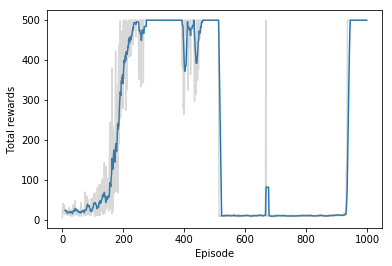

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

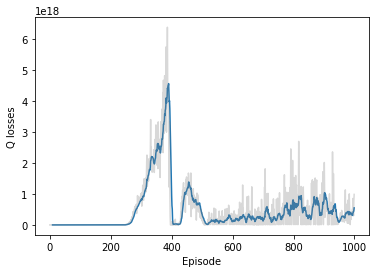

In [35]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, _, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [38]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.